# Toxic Comments Classification
### ML First Iteration_ Assignment 1

#### The following notebook documents the first iteration on the toxic comments dataset

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
#added countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### Function for feature building and extraction on Natural Language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 13, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv) #what is this doing?
        print("Shape of HashingVectorizer X:")    
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\!")
    # should it be a boolean value? As str.find returns an index; how will a boolean be converted to 0 or 1
    toxic_data['occur_fuck'] =(toxic_data['comment_text'].str.lower().str.count("fuck"))
#     toxic_data['occur_cock'] =(toxic_data['comment_text'].str.lower().str.count("cock"))
    toxic_data['occur_shit'] =(toxic_data['comment_text'].str.lower().str.count("shit"))
    toxic_data['uppercase_letters'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    

    X_quant_features = toxic_data[[ "word_count","occur_fuck", "occur_shit", "punc_count", "uppercase_letters"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=56)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

### Model : SVM, Linear

In [24]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(max_iter=2000, alpha=0.01)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12926, 'Neg': 114730, 'TP': 9307, 'TN': 113684, 'FP': 1046, 'FN': 3619, 'Accuracy': 0.9634564767813498, 'Precision': 0.8989664831449822, 'Recall': 0.7200216617669812, 'desc': 'svm_train'}


### Looking at some false positives

In [27]:
svm_predictions = svm.predict(X_train)

In [29]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(svm_predictions)):
    if (svm_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

Examples of false positives:
1023
Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. 
Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary.
Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary.
Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary.Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise me in an edit summary. Recognise

26999
ha ha how are you gonna stop me?
* * * * * * * * * 
27140
They are saying that in the real world, 'monetarism' using targetting of amounts of money cannot work and will always fail - if more base money is available to be added.
* * * * * * * * * 
30544
wow, this is bs
i am not a sockpuppet, wow...
* * * * * * * * * 
36249
I refer you to the crap as discussed above around 11 November, for starters. Anyway, like I said, it is probably best that I retire. -
* * * * * * * * * 
37206
Holding Jews to higher standards than Arabs is racist. Do you think Arabs are inferior to Jews?
* * * * * * * * * 
43779
Truth is an absolute defense to libel.  You are lying.  And you are harassing me.
* * * * * * * * * 
44481
. Your sources are worthless
* * * * * * * * * 
47394
If you check http://en.wikipedia.org/wiki/CeCe_Peniston_discography you would understand what I mean. That is my whole work, pretty tiresome. Can I get back please those two lost sections for songs Still I and My Boo? Benuliak
*

119143
You know who I am Big Brother
* * * * * * * * * 
119802
REDIRECT Talk:Battle of Tinzaouaten
* * * * * * * * * 
120920
Hobo the Dodo, you have little authority, you are warned, you cannot stop TVHOSTED.
* * * * * * * * * 
121240
Listen to them... 

...children of the night. What music they make. 62.216.118.84
* * * * * * * * * 
123197
HIV spread by splitting of the anus. It is the blood from the anus leaking into the penis that activates the HIV virus. HIV just needs to be activated. Say no to anal sex, and preserve the human race.
* * * * * * * * * 
126317
Now you are piling on.
* * * * * * * * * 


### Test Set performance

Since we are concerned with the minority class (that of positives for toxicity), optimizing precision and the true positive rate is more important that optimizing the true negative rate and accuracy (which is biased towards the majority class - negative for toxicity)

In [30]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3299, 'Neg': 28616, 'TP': 2123, 'TN': 28006, 'FP': 610, 'FN': 1176, 'Accuracy': 0.9440388532038226, 'Precision': 0.7768020490303695, 'Recall': 0.6435283419217945, 'desc': 'svm_test'}


### ROC Plot for training and test data set

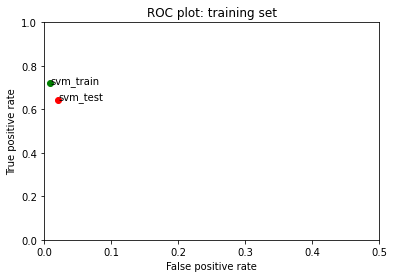

In [42]:
fits = [svm_performance_train, svm_performance_test]

plt.plot(fits[0].performance_measures['FP']/fits[0].performance_measures['Neg'],
         fits[0].performance_measures['TP']/fits[0].performance_measures['Pos'], 'bo', color="green")
plt.plot(fits[1].performance_measures['FP']/fits[1].performance_measures['Neg'],
         fits[1].performance_measures['TP']/fits[1].performance_measures['Pos'], 'bo', color="red")

for fit in fits:
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.5, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## SUBMSSION 

In [43]:
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=80, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 8192)
Look at a few rows of the new quantitative features: 
   word_count  occur_fuck  occur_shit  punc_count  uppercase_letters
0          72           2           1           0                  4
1          13           0           0           0                  7
2          16          

In [44]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.19266929565694288


In [46]:
raw_data.head()

,id,comment_text,word_count,punc_count,occur_fuck,occur_shit,uppercase_letters
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,0,2,1,4
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,0,0,0,7
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,0,4
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,0,0,0,4
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,0,0,0,1


In [47]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [50]:
my_submission.shape

(153164, 2)

In [52]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('sample_submissions/toxiccomments_submission.csv', index=False)